# ST7 Planification quotidienne d’une équipe mobile

In [1]:
# Modules de base
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Utilités
from math import ceil
from utils import plot_map

### Notations
- $ W $ : Nombre de tâches (W pour work)
- $ U $ : Nombre d’indisponibilités (unavail pour Unavailable)
- $ T $ : Nombre de employés (T pour Technician)
- $ V = 2 \times T + W + U$ : Le nombre total de nœuds

### Les indices des nœuds

Tout comme notre modèle dans la phase 1, Dans notre modèle pour la phase 2, nous allons utiliser le modèle de graphe pour résoudre notre problème. Dans la phase 1, les nœuds sont les tâches à effectuer, ainsi qu’un nœud symbolisant le dépôt initial d’où partent les employés. Dans la phase 2, le rajout de contraintes tels que la pause midi/déjeuner et les indisponibilités nous amène à distinguer quatre types de nœuds : Les lieux de résidences des employés (home), les tâches (task), les nœuds auxiliaires fictifs/dummy nodes correspondant aux pauses déjeuners des employés (lunch) et enfin les indisponibilités (unavail). Afin de faciliter la lecture, nous utilisons les notations suivantes pour les indices des quatre types de nœuds : 

- $ homes = \{0, ..., T - 1\} $ sont les indices des lieux de résidence / maison des employés
- $ lunches = \{T, ..., 2T - 1\} $ : les indices des pauses midi, ie. les déjeuners
- $ tasks = \{2T, ... 2T + W - 1\} $ : les indices des tâches à réaliser
- $ unavails = \{2T + W, ..., V - 1 \} $ : les indisponibilités des employés

L’ensemble des nœuds est donc : 
- $ nodes = homes \cup lunches \cup tasks \cup unavails = \{0, ..., V - 1\} $

Quant aux indices des employés, ils sont les mêmes que les indices de leurs maisons : 
- $ employees = \{0, ..., T - 1 \} $

Par la suite, lorsque l’on note $i \in homes$, cela signifie $i \in \{0, ..., T - 1\}$, idem pour les autres types de nœuds.

Les nœuds homes, lunches, unavails doivent être visité par leurs employés correspondants. Nous utilisons les notations suivantes pour ces correspondances : 
- $ home(k), k \in employees $ : L’indice du lieu de résidence de l’employé k
- $ lunch(k), k \in employees $ : L’indice du nœud correspondant à la pause déjeuner de l’employé k. Nous modélisons la pause déjeuner comme une tâche fictive.

Dans la phase 2 du projet, les tâches sont ouvertes sur plusieurs créneaux de temps. Les indisponibilités sont notées : 
- $ closed(i), i \in tasks $ : Ensemble des (start, end) des indisponibilités de la tâche i.

Notez que ce ne sont pas des variables de décisions et ne changent pas au cours du temps, malgré la notation entre parenthèse.

### À propos des pauses déjeuners
Dans une perspective de pure optimisation, nous aurions pu considérer que les employés effectuent leurs pauses déjeuners en plein milieu de la trajectoire rectiligne du trajet entre une tâche et la suivante. Pourtant, il nous semble que cette manière de représenter les pauses déjeuners correspondent peu à la réalité, et il nous paraît plus naturel qu’après avoir effectué la dernière tâche du matin, un employé mange et se repose sur place, et ensuite qu’il prenne sa route vers la prochaine destination. Cela nous amène à modéliser les pauses déjeuners ainsi :

Nous modélisons les pauses midi de chaque employé comme une «pseudo-tâche» d’une durée d’une heure, qui s’ouvrent à 12h et qui ferment à 14h, que l’employé doit obligatoirement effectuer. Comme l’employé effectuer cette tâche sur place (donc pas de temps de trajet entre la dernière tâche du matin et la pause déjeuner, la pause déjeuner a une distance de 0 vers les autres nœuds. Un employé effectuer la dernière tâche du matin, se rend sur cette « pseudo-nœuds », et ensuite retourne vers le nœud de la tâche du matin, comme illustre l’image suivante : 


<img src="./images/lunch_illustration.jpeg" alt="lunch-illustration" width=500>

### Nous notons les constantes suivante : 

- $ opening_i, i \in tasks \cup unavails $ : l’ouverture de la tâche i / début de l’indisponibilité i
- $ closing_i, i \in tasks \cup unavails $ : la fermeture de la tâche i / fin de l’indisponibilité i
- $ start_k, k \in employees $ : le début de la journée de l’employé k
- $ end_k, k \in employees $ la fin de la journée de d’employé k
- $ duration_i $ : la durée de la tâche/indisponibilité/ i
- $ distance_{i, j} $ : la distance entre le nœud i et le nœud j
- $ speed $ : la vitesse de déplacement des techniciens

### Variables de décisions
- $ (x_{i, j})_{i , j \in nodes \times nodes, i \neq j} $, $ x_{i, j} = 1 $ ssi. (i, j) est un arc de i vers j
- $ (y_{k, i})_{k \in employees, i \in tasks} $, $ y_{k, i} = 1 $ ssi. le technicien k se rend au nœud i (Pour les indices i correspondant aux lieux de résidence/ pauses déjeuners /indisponibilités des employés, la notation est la même, sauf que les valeurs sont fixes car on connaît la relation entre ces nœuds et leurs employés correspondants)
- $ (b_i)_i $, $b_i$ est le début de chaque tâche en minute (b pour beginning)

### Contraintes :

- (C1) Chaque nœud doit avoir autant d’entrée que de sorties
$$ \forall i \in nodes, \sum_{j = 0}^{V - 1} x_{i, j} = \sum_{j = 0}^{V - 1} x_{j, i} $$

En effet, les employés doivent former des cycles en partant de son lieu de résidence, et en terminant son parcours à son lieu de résidence. Cette condition est une condition nécessaire pour avoir que les parcours soient cycliques.

- (C2) Une tâche est effectuée par au plus un employé
$$ \forall i \in tasks, \sum_{j \in tasks \cup homes \cup unavails} x_{i, j} \le 1$$

Pour les tâches, une tâche est effectuée par un plus un employé, donc il a zéro arc entrant/sortant s’il n’est pas effectuée, et une entrée/sortie s’il est effectué. Comme chaque nœud a autant d’arcs entrant que d’arcs sortant, nous ne comptons ici seulement les arcs sortants.

Notons que nous ne comptabilisons pas les arcs sortants vers les «pseudo-nœuds» pauses midis, car ces arcs ne correspondent pas à de vrais trajets.

- (C3) Les indisponibilités, maisons et pauses déjeuners doivent obligatoirement être visités :
$$ \forall i \in unavails \cup lunches \cup homes, \sum_{j \in nodes} x_{i, j} = 1 $$

Remarque : Même lorsque l’employé reste inactif, sa pause déjeuner fait que sa maison a une paire d’arc entrant/sortant.

- (C) Les employés doivent visiter les nœuds correspondant à leurs indisponibilités, leurs pauses déjeuners et leurs lieux de résidence.
$$ \forall k \in employees, \forall i \in home(k) \cup lunche(k) \cup unavails(k), y_{k,i} = 1 $$

- (C) Deux nœuds qui se suivent doivent être attribué à la même personne
$$ \forall i, j \in \{1,\dots, V-1\}, x_{i, j} \implies \forall k \in \{0,\dots, T-1\}, y_{k, i} = y_{k, j} $$

- (C) Lorsqu’un travail est effectué sur une tâche, le site de la tâche doit être ouverte.
$$ \forall i \in Tasks \cup lunches, (b_i \ge opening_i) \land (b_i + duration_i \le closing_i) $$
Pour les déjeuners, le opening time et closing time sont 12h et 14h.

- (C) Lorsqu’un travail est effectué sur une tâche, la tâche doit être disponible.
$$ \forall i \in Tasks, \forall (start_{un}, end_{un}) \in unavailabilities(i): $$
$$ b_i \ge end_{un} \lor b_i + duration_i \le start_{un} $$

- (C) Un technicien doit avoir suffisamment de temps pour arriver au premier nœuds (après avoir quitté son lieu de résidence)
$$ \forall k \in \{0, ..., T - 1\}, \forall i \in nodes, X_{home(k), i} \implies start_k + \frac{distance(home(k), i)}{speed} \le b_i$$
Remarque : les $b_i$ pour les indisponibilités des employés correspondent au début de l’indisponibilité. (Un employé doit avoir assez de temps pour aller à l’événement qui a causé son indisponibilité)

- (C) Après avoir visité tous les nœuds qui lui sont attribué, un employé doit avoir suffisamment de temps pour rentrer chez lui :
$$ \forall k \in \{0, ..., T - 1\}, \forall i \in Nodes, x_{i, home(k)} \implies b_i + duration_i + \frac{distance_{home(k), i}}{speed} \le end_k $$
- $$ \forall k \in \{0, ..., T - 1\}, \forall i \in Unavailabilities, x_{i, home(k)} \implies end_i + \frac{distance_{home(k), i}}{speed} \le end_k $$

- (C) Chaque employé doit effectuer une pause déjeuner.
$$\forall k \in employees, y_{lunch(k), k} = 1$$

- (C) Après la pause déjeuner, l’employé doit se trouver là où il se trouvait au début de la pause déjeuner. (L’arc sortant et l’arc entrant au déjeuner doit connecter le déjeuner au même site)
$$ \forall k \in employees, \forall i \in nodes, x_{home(k), i} \iff x_{i, home(k)}$$

- (C) Une noeud est visité par exactement un seul employé
$$ \forall i \in \{1,\dots, V-1\}, \sum_{k=0}^{T-1} y_{k, i} = 1 $$

- (C) Le temps de trajet entre deux nœuds (dont aucun est un lieu de résidence) doit être suffisant :
$$ \forall i, j \in Unavails \cup Tasks, x_{i, j} \implies b_i + duration_i + \frac{disatnce_{i, j}}{speed} \le b_j $$


- (C) Un technicien n’effectue que des tâches qu’il est capable d’effectuer
$$ \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, levelTech_k \ge levelTask_i - M \cdot (1 - y_{k, i}) $$

## Implémentation d'employé et tâche

In [62]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from utils import parse_time, parse_time_minute


class Employee:
    list = []  # initialized to empty list
    count = 0
    speed = 50 * 1000 / 60  # unit: meter/minute
    __name_employee_correspondance = {}

    def __init__(self, name: str, latitude: float, longitude: float, skill: str, level: int, start_time, end_time):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.skill = skill
        self.level = level
        self.start_time_str = parse_time(start_time)  # parse time into datetime object for printing
        self.end_time_str = parse_time(end_time)
        self.start_time = parse_time_minute(start_time)  # parse time into minutes
        self.end_time = parse_time_minute(end_time)
        Employee.count += 1
        Employee.list.append(self)
        Employee.__name_employee_correspondance[name] = self

    @classmethod
    def find_by_name(cls, name):
        return cls.__name_employee_correspondance[name]

    @classmethod
    def load_excel(cls, path):
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")

        for index, row in df_employees.iterrows():
            Employee(row["EmployeeName"],
                     row["Latitude"],
                     row["Longitude"],
                     row["Skill"],
                     row["Level"],
                     row["WorkingStartTime"],
                     row["WorkingEndTime"])

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return self.name == other.name

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"Employee(name={self.name}, " \
               f"position=[{self.longitude}, {self.latitude}], " \
               f"skill_requirement=level {self.level} {self.skill}," \
               f"available=[{self.start_time_str.strftime('%I:%M%p')}, {self.end_time_str.strftime('%I:%M%p')}] )"

In [69]:
class Node:
    list = []
    count_node = 0
    count_task = 0
    count_unavail = 0
    distance: np.array = None
    __is_initialized = False

    def __init__(self, task_id, latitude, longitude, duration, skill, level, opening_time, closing_time,
                 node_type: str):
        if Node.__is_initialized:
            raise Exception("Cannot instantiate new task after initializing the distance matrix")
        self.id = task_id
        self.latitude = latitude
        self.longitude = longitude
        self.duration = duration
        self.skill = skill
        self.level = level
        self.opening_time_str = parse_time(opening_time)
        self.closing_time_str = parse_time(closing_time)
        self.opening_time = parse_time_minute(opening_time)
        self.closing_time = parse_time_minute(closing_time)
        self.node_type = node_type # home, lunch, task, unavail

        if node_type in ["home", "lunch", "unavail"]:
            self.employee = Employee.find_by_name(task_id)

        if node_type == "task":
            Node.count_task += 1

        if node_type == "unavail":
            Node.count_unavail += 1

        Node.count_node += 1
        Node.list.append(self)

    @classmethod
    def load_excel(cls, path, initialize_distance=False):

        # load homes
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")
        for _, row in df_employees.iterrows():
            Node(row["EmployeeName"], row["Latitude"], row["Longitude"], 0, None, 0, None, None, "home")

        # load dummy node for lunch
        df_employees = pd.read_excel(path, sheet_name="Employees")
        df_employees.set_index("EmployeeName")
        for _, row in df_employees.iterrows():
            Node(row["EmployeeName"], None, None, 60, None, 0, "12:00am", "2:00pm", "lunch")

        # load tasks
        df = pd.read_excel(path, sheet_name="Tasks")
        df.set_index("TaskId")
        for index, row in df.iterrows():
            # parse the start time and end time into datetime object
            opening_time = datetime.strptime(row["OpeningTime"], '%I:%M%p')
            closing_time = datetime.strptime(row["ClosingTime"], '%I:%M%p')

            Node(row["TaskId"],
                 row["Latitude"],
                 row["Longitude"],
                 row["TaskDuration"],
                 row["Skill"],
                 row["Level"],
                 opening_time,
                 closing_time, node_type="task")

        # create a task for each unavailability at the bottom of the list
        df_employees_unavailabilities = pd.read_excel(path, sheet_name="Employees Unavailabilities")
        df_employees_unavailabilities.set_index("EmployeeName")
        for _, row in df_employees_unavailabilities.iterrows():
            open_time = row["Start"]
            close_time = row["End"]
            duration = parse_time_minute(close_time) - parse_time_minute(open_time)
            Node(row["EmployeeName"], row["Latitude"], row["Longitude"], duration, None, 0, open_time, close_time,
                 node_type="unavail")

        if initialize_distance:
            cls.initialize_distance()

    @staticmethod
    def calculate_distance(task1, task2):
        if task1.node_type == "lunch" or task2.node_type == "lunch":
            return 0
        lon1, lat1 = radians(task1.longitude), radians(task1.latitude)
        lon2, lat2 = radians(task2.longitude), radians(task2.latitude)

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371 * 1000  # radius of earth
        return c * r

    @classmethod
    def initialize_distance(cls):
        if cls.__is_initialized:
            print("Warning: trying to reinitialize an initialized task list, recalculating the distance matrix")
        cls.__is_initialized = True
        cls.distance = np.zeros((len(Node.list), len(Node.list)), dtype=np.float64)

        for i in range(cls.count_node):
            for j in range(i):
                task_i, task_j = cls.list[i], cls.list[j]
                cls.distance[i, j] = cls.distance[j, i] = cls.calculate_distance(task_i, task_j)

    @classmethod
    def get_home_correspondances(cls):
        pass

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, other):
        return self.id == other.id

    def __repr__(self):
        # opening_time = self.opening_time_str.strftime('%I:%M%p')
        # closing_time = self.closing_time_str.strftime('%I:%M%p')

        if self.node_type == "task":
            return f"Task(id={self.id}, " \
                   f"position=[{self.longitude}, {self.latitude}], " \
                   f"duration={self.duration}, " \
                   f"skill_requirement=level {self.level} {self.skill}," \
                   f"opening_time=[{self.opening_time_str.strftime('%I:%M%p')}" \
                   f"to {self.closing_time_str.strftime('%I:%M%p')}] "

        if self.node_type == "lunch":
            return f"Lunch({self.id})"

        if self.node_type == "home":
            return f"Home({self.id})"

        if self.node_type == "unavail":
            return f"Unavailability({self.id}, start={self.opening_time_str.strftime('%I:%M%p')}, end={self.closing_time_str.strftime('%I:%M%p')})"

### Quelques démos de l’implémentation

In [70]:
path_bordeaux = "./data/InstancesV2/InstanceBordeauxV2.xlsx"
path = path_bordeaux
# path_result = "results/SolutionBordeauxV1ByV1.txt"

In [71]:
# reading dataframe into python objects
Employee.load_excel(path)
Node.load_excel(path, initialize_distance=True)
print(Node.count_node, Node.count_task, Node.count_unavail)
print(Employee.count)

15 10 1
4


In [72]:
Node.distance

array([[     0.        ,  23906.83058516,      0.        ,
             0.        ,  77088.14164263,  26425.09673473,
          6932.25850055,  13231.21025159,  16907.60607192,
          8018.39052859,  29654.86503583,  14251.83756639,
         18127.03789041,   7855.55497962,      0.        ],
       [ 23906.83058516,      0.        ,      0.        ,
             0.        ,  58439.72228403,  17830.47320533,
         24334.2333104 ,  36821.29720994,  17526.58502259,
         30020.55226258,  52398.27454399,   9870.88501072,
         40509.07363752,  16256.55330524,  23906.83058516],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.    

In [66]:
T = len(Employee.list)
V = len(Node.list)
print(f"Fichier d’origine : \"{path}\"")
print(f"Nombre d’employés : {T}, Nombre de tâches : {V}")

Fichier d’origine : "./data/InstancesV2/InstanceBordeauxV2.xlsx"
Nombre d’employés : 2, Nombre de tâches : 15


Essayons maintenant d’afficher notre première tâche dans le fichier excel

In [68]:
Node.list

[Home(Valentin),
 Home(Ambre),
 Lunch(Valentin),
 Lunch(Ambre),
 Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T2, position=[-0.6086852638150881, 44.96750095217799], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T3, position=[-0.7342570469020379, 45.14421541464031], duration=60, skill_requirement=level 2 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T4, position=[-0.7717887212411139, 45.264808304867096], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T5, position=[-0.6687606009488057, 45.044422793402624], duration=60, skill_requirement=level 2 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T6, position=[-0.7462077931750715, 45.19957452440505], duration=60, skill_requirement=level 2 Oenology,opening_time=[08:00AMto 06:00PM] ,
 Task(id=T7, position=[-0.9668192708194538, 45.39769

## Implémentation

### Objective d'optimisation

In [11]:
assert m.status != GRB.INFEASIBLE

In [12]:
print("Techniciens actifs : {}".format([k for k in range(T) if t[k].x == 1]))

for k in range(T):
    print("Y_{} : {}".format(k,[i for i in range(1,V) if Y[(k,i)].x == 1]))
print()
for i in range(V):
    print([(i,j) for j in range(V) if i != j and X[(i,j)].x == 1])
print()
print(["B_{} : {}".format(i,B[i].x) for i in range(V)])

Techniciens actifs : [0, 1]
Y_0 : [3, 4, 5, 6, 7, 9]
Y_1 : [1, 2, 8, 10]

[(0, 2), (0, 9)]
[(1, 8)]
[(2, 1)]
[(3, 5)]
[(4, 6)]
[(5, 0)]
[(6, 3)]
[(7, 4)]
[(8, 10)]
[(9, 7)]
[(10, 0)]

['B_0 : -0.0', 'B_1 : 804.0', 'B_2 : 682.0', 'B_3 : 801.0', 'B_4 : 663.0', 'B_5 : 876.0', 'B_6 : 733.0', 'B_7 : 577.0', 'B_8 : 942.0', 'B_9 : 502.0', 'B_10 : 1010.0']


In [13]:
# Z associe un indice de tâche à l'employé qui l'effectue
Z = {}
for i in range(V):
    for k in range(T):
        if Y[(k,i)].x == 1:
            Z[i] = k

### Enregistrement des données dans le bon format

In [14]:
if not os.path.isdir(path_result):
    store_result(target_path=path_result,
                 employees=Employee.list,
                 tasks=Task.list, z=Z, b=B)

### Affichage de la distance totale

In [15]:
print(f"The total distance is {max([Task.distance[i,j] for i in range(V) for j in range(V)])/Employee.speed} km(s)")

The total distance is 127.79477073284689 km(s)


### Maintenant essayons d’utiliser notre visualiseur pour voir comment notre algorithem a réglé le problème

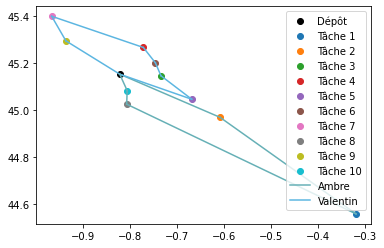

In [16]:
plot_map(V, Employee.list, Task.list, X, Z)

## Il suffit ensuite de changer les variables path et path_result pour faire les culculs sur les autres instances